# Analysis of systematic prediction errors in the rgc2lgn model

TODO: 

## Setup

In [72]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.decomposition import PCA

# import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.gridspec as gridspec
%matplotlib inline

## Parameters

In [2]:
# Directories
data_dir = '../data/'

# Model type
# % OPTIONS:
# % - 'lin': linear
# % - 'lin_nonneg': linear w non-neg constraint
# % - 'lin_nonneg_exp2': linear with non-neg constraint + two-term exponential
# % - 'lasso': linear model w elastic net regularization
# % - 'glm': Generalized linear model with exponential non-linearity
# % - 'lassoglm': Generalized linear model with exponential non-linearity & elastic net regularization
model_type = 'lin_nonneg'


TODO: import custom_plot_pars

In [125]:
# # Plotting pars
# plot_par = {
#     'figure.figsize': [12,4],
# }

# rcParams.update(plot_par)

In [ ]:
# mpl.rcParams["figure.facecolor"]
# mpl.rcParams["axes.facecolor"]
# mpl.rcParams["savefig.facecolor"]

In [3]:
## Utils functions
# TODO: outsource to utils
def custom_plot_pars():
    """Returns custom plot parameters."""
    plot_pars = {
        'figure.facecolor': 'white',        
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.linewidth': 1.0,
        'axes.titlesize': 20,
        'figure.frameon': False,
   #         ‘figure.autolayout’: True
        'font.size': 15,
        'figure.figsize': [12.0, 4.0],
        'legend.frameon': False,
        'legend.fontsize': 15,
        'xtick.major.size': 6.5,
        'ytick.major.size': 6.5,
          }
    return plot_pars

def every_nth_ticklabel(axis, every_nth=2):
    """Shows only every nth ticklabel."""
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

In [4]:
plot_pars = custom_plot_pars()
rcParams.update(plot_pars)

# sns.set_style("white") # Remove background grid (sets for all plots?)
# Standard color map (reverse) (check alternative setup methods later)
# sns.set_palette('Blues_r')

## Load & transform data

In [5]:
ffname = data_dir+'model_'+model_type+'.mat'
print('Loading model:', ffname)
model = loadmat(ffname)

Loading model: ../data/model_lin_nonneg.mat


In [6]:
# Get dLGN cell responses and model predictions from RGC clusters
resp_orig = model['model_units']
pred_orig = model['model_y_hat']

print("Responses shape: (cell, time, cross-val) =", resp_orig.shape)
print("Predictions shape: (cell, time, cross-val) =", pred_orig.shape)

# Average across cross-validations
resp = np.mean(resp_orig, 2)
pred = np.mean(pred_orig, 2)

# Exclude cell with no model
resp = resp[~np.all(resp == 0, axis=1)]
pred = pred[~np.all(pred == 0, axis=1)]
print("Final responses shape: (cell, time) =", resp.shape)
print("Final predictions shape: (cell, time) =", pred.shape)

Responses shape: (cell, time, cross-val) = (815, 249, 1000)
Predictions shape: (cell, time, cross-val) = (815, 249, 1000)
Final responses shape: (cell, time) = (814, 249)
Final predictions shape: (cell, time) = (814, 249)


In [23]:
# Get time vector
rgc = model['rgc']
t = rgc[0,0][0].T
print(t.shape)

(249, 1)


## Plot example cells

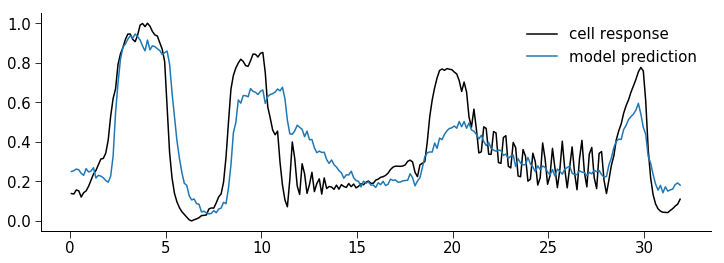

In [24]:
ndx = 451 # [153]
plt.plot(t, resp[ndx,:], 'k', label='cell response')
plt.plot(t, pred[ndx,:], label='model prediction')
# ax.set_facecolor('white')
plt.legend()

## Compute and plot example residuals

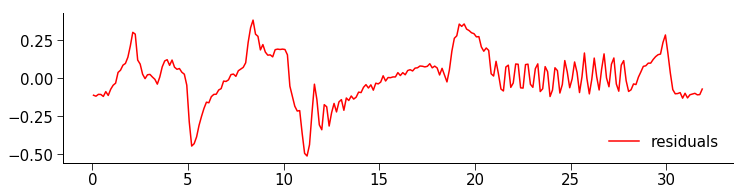

In [32]:
# Compute residuals (all cells)
res = resp-pred
plt.figure(figsize=(12,2.75))

plt.plot(t, res[ndx,:], 'r', label='residuals')
plt.legend()

## Compute PCA on residuals

In [43]:
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(res)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

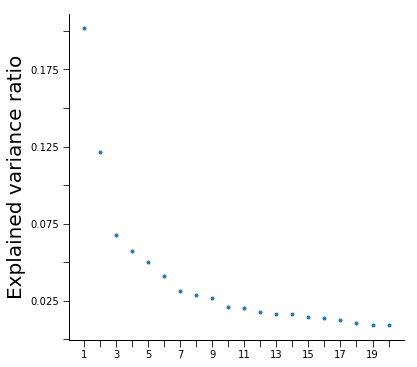

In [75]:
# Plot explained variance ratio

plt.figure(figsize=(6,6))

plt.plot(pca.explained_variance_ratio_, '.')
plt.ylabel('Explained variance ratio', fontsize=rcParams['axes.titlesize'])

# Adjust plot
x = np.arange(ncomp)
ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(x+1)
every_nth_ticklabel(ax, every_nth=2)

plt.show()

The EV distribution suggests that maybe the first two PCs are larger than random

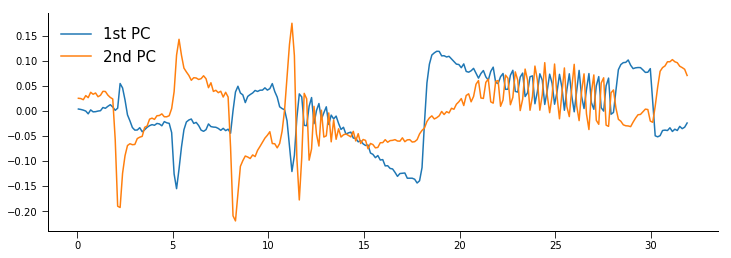

In [74]:
# Plot first and second PCA component

plt.figure(figsize=(12,4))

plt.plot(t, pca.components_[0,:].T, label='1st PC')
plt.plot(t, pca.components_[1,:].T, label='2nd PC')
plt.legend()

Interestingly, they basically correspond to missed on and off transients...

## Compute the PCA coefficients and look at the cells most strongly affected by that component.

In [70]:
coeff = pca.transform(res)[:,0:2]

### Look at the top 5 cells for component 1

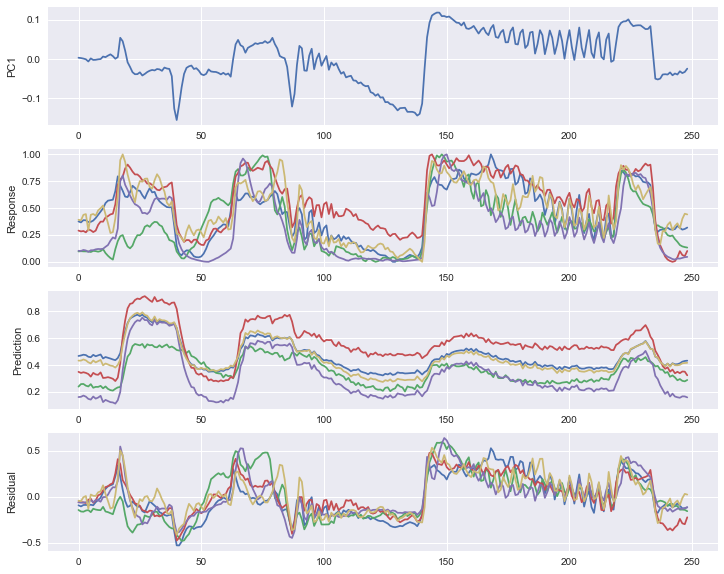

In [95]:
comp = 0
ncells = 5
ndx = np.argsort(coeff[:,comp])[::-1]

plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(pca.components_[comp,:].T)
plt.ylabel('PC'+str(comp+1))

plt.subplot(4,1,2)
plt.plot(resp[ndx[range(ncells)],:].T)
plt.ylabel('Response')

plt.subplot(4,1,3)
plt.plot(pred[ndx[range(ncells)],:].T)
plt.ylabel('Prediction')

plt.subplot(4,1,4)
plt.plot(res[ndx[range(ncells)],:].T)
plt.ylabel('Residual')

### Look at the top 5 cells for component 2

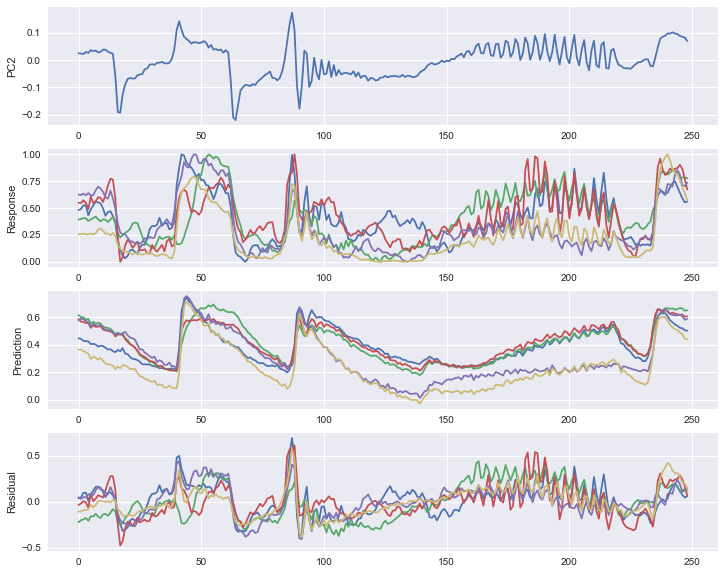

In [96]:
comp = 1
ncells = 5
ndx = np.argsort(coeff[:,comp])[::-1]


plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(pca.components_[comp,:].T)
plt.ylabel('PC'+str(comp+1))

plt.subplot(4,1,2)
plt.plot(resp[ndx[range(ncells)],:].T)
plt.ylabel('Response')

plt.subplot(4,1,3)
plt.plot(pred[ndx[range(ncells)],:].T)
plt.ylabel('Prediction')

plt.subplot(4,1,4)
plt.plot(res[ndx[range(ncells)],:].T)
plt.ylabel('Residual')

# TESTING

In [ ]:
# x = np.arange(0, 35, 10)
# ax4.set_xticks(x)
# ax4.set_xticklabels(x)